# Test Data Quality from a Muse-lsl recording

(based off the MNE stuff in the SSVEP notebook)

The idea is to do a quick test here before spending hours recording with bad signal quality...

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#sys.path.append('../muse')
sys.path.append('../muse')
import utils

## Load data into MNE objects

In [10]:
fnames = ['../data_2018-04-22-23.11.06.csv','../data_2018-04-22-23.16.58.csv']

In [11]:
raw = utils.load_muse_csv_as_raw(fnames, sfreq=256., ch_ind=[0,1,2,3,4],
                                stim_ind=5,
                                replace_ch_names={'Right AUX': 'POz'})

Creating RawArray with float64 data, n_channels=6, n_times=5136
    Range : 0 ... 5135 =      0.000 ...    20.059 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=5136
    Range : 0 ... 5135 =      0.000 ...    20.059 secs
Ready.


## Epoch, with amplitude-based artefact rejection

Ok so here's the problem: my recordings always get rejected with the criterion used in the original notebooks

In [16]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

11 events found
Events id: [1 2]


In [17]:
epochs

<Epochs  |  n_events : 0 (all good), tmin : -0.5 (s), tmax : 4.0 (s), baseline : None, ~21 kB, data loaded,
 '20 Hz': 0, '30 Hz': 0>

...they survive if that's taken down a notch...

In [18]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None,
                reject={'eeg': 100e-5}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3, 4])

11 events found
Events id: [1 2]


In [19]:
epochs

<Epochs  |  n_events : 9 (all good), tmin : -0.5 (s), tmax : 4.0 (s), baseline : None, ~426 kB, data loaded,
 '20 Hz': 2, '30 Hz': 7>

## Plot spectrum

Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


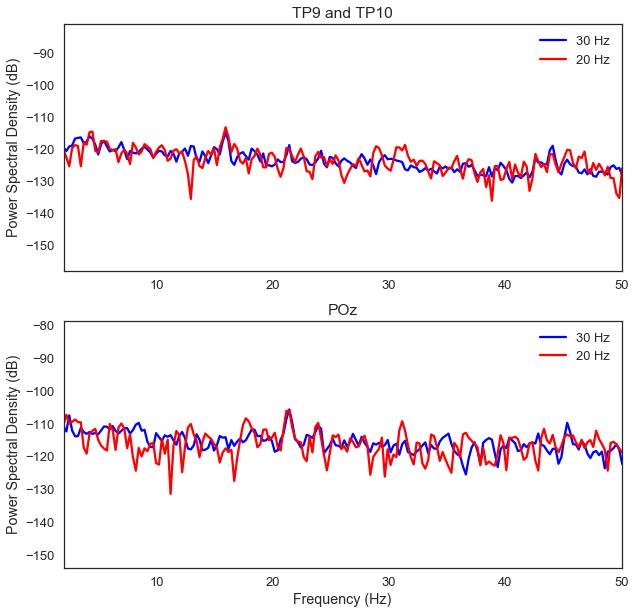

In [29]:
from mne.time_frequency import psd_welch

f, axs = plt.subplots(2, 1, figsize=(10, 10))
psd1, freq1 = psd_welch(epochs['30 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['20 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='30 Hz')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='20 Hz')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim((2, 50))
axs[1].set_xlim((2, 50))
axs[1].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()

plt.show()